In [1]:
#housekeeping and essential imports
import pandas as pd
import os
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1800)
pd.set_option ('display.max_colwidth', 70)
pd.set_option('display.max_columns', 50)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Section I. initial processing of the \*bedA files

In [195]:
DIR = os.path.join(os.path.expanduser("~"),"Downloads/denonovoPAStestoutput/")

# use dataframe to calculate unique counts

import glob
#grab all files ending with .bedA
filels = glob.glob(os.path.join(DIR, "*.bedA*"))

os.chdir("/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/")

filesize_ls=[]
for l in filels: 
    filesize_ls.append(os.path.getsize(l)) # get file size info

files = pd.DataFrame({"Name":filels, "Size":filesize_ls}) #dataframe to store file names(full path) and file size

filtered_files = files[files.Size >0] #filter through only files with size > 0, these are the files that have matches

filtered_files.reset_index(inplace=True, drop=True) # reset row index

filtered_files['dataset']  = filtered_files['Name'].str.extract('\w+output/(F\d+)\w+\.bedA$', expand=False) # extract dataset from file name

 #### get reads per utr region

In [238]:
total_reads=[] #store reads per utr region
df2=pd.DataFrame([]) # store results from all files into one dataframe
for i in range(0,len(filtered_files)):
    df = pd.read_csv(os.path.join(DIR, filtered_files['Name'][i]), sep=" ", header=None) # read all files with size > 0
    df.columns = ["ref_chromosome", "ref_start", "ref_end", "transcript_id", "strand", "gene", "read_chromosome", "read_start", "read_end"] # name columns
    df['dataset'] = filtered_files['dataset'][i] # add dataset info
    total_reads = df.groupby(["ref_start", "ref_end"])['read_start'].count() # add reads per utr region as column
    df['reads_per_utr'] = total_reads[0]
    df2 = pd.concat([df2, df]) # process all files (dataframes) and combine into one dataframe
    total_reads=[] # this is temprorary for the iteration

In [239]:
df2.reset_index(drop=True, inplace=True)

In [263]:
df2.head() #Note df2 has duplicats because it flattens content from all files into one dataframe


,ref_chromosome,ref_start,ref_end,transcript_id,strand,gene,read_chromosome,read_start,read_end,dataset,reads_per_utr
0,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978147,39989222,F231,1577
1,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978151,39988962,F231,1577
2,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978151,39989221,F231,1577
3,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978151,39989216,F231,1577
4,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978151,39988562,F231,1577


#### Histogram data for reads_per_utr

In [243]:
hist_col = ['ref_chromosome', 'ref_start', 'ref_end', 'transcript_id', 'strand', 'dataset', 'reads_per_utr'] #columns for the histogram data

In [244]:
hist_data = df2[hist_col].drop_duplicates().sort_values(by=['dataset','ref_start', 'ref_end']).reset_index(drop=True) #get unique count (reads_per_utr) for each utr region

In [174]:
#hist_data.to_csv("hist_data.csv", index=False, sep="\t", header=True) #export to csv

In [246]:
hist_data.shape
hist_data.head()

(153, 7)

,ref_chromosome,ref_start,ref_end,transcript_id,strand,dataset,reads_per_utr
0,chr20,3190005,3190263,uc031rsf.1,+,F231,5
1,chr20,9459656,9461462,uc021wam.1,+,F231,6
2,chr20,18123001,18123812,uc021wba.1,+,F231,156
3,chr20,23356709,23358012,uc010zss.1,-,F231,3
4,chr20,24943579,24944636,uc010zsw.2,-,F231,709


In [287]:
hist_data[hist_data.reads_per_utr >= 50].head()

,ref_chromosome,ref_start,ref_end,transcript_id,strand,dataset,reads_per_utr
2,chr20,18123001,18123812,uc021wba.1,+,F231,156
4,chr20,24943579,24944636,uc010zsw.2,-,F231,709
10,chr20,25426558,25429191,uc010zte.1,+,F231,66
16,chr20,32676114,32677450,uc031rsu.1,-,F231,4545
17,chr20,33148345,33148783,uc010zul.2,-,F231,155


In [299]:
names = hist_data[hist_data.reads_per_utr >= 50][['ref_chromosome', 'ref_start', 'ref_end', 'dataset']].drop_duplicates()

In [322]:
filtered_bedA_files = names['dataset'] + names['ref_chromosome'] + '_' + names['ref_start'].map(str) + '_' + names['ref_end'].map(str) + '.bedA'

In [325]:
os.getcwd()

'/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput'

In [326]:
filtered_bedA_files.to_csv(os.path.join("/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput", "filtered_bedA_files.csv"), sep="\t", index=False, header=None)

In [261]:
hist_data[hist_data.dataset.isin(['F231'])].reads_per_utr.describe()

count      81.000000
mean      207.185185
std       787.462001
min         1.000000
25%         1.000000
50%         5.000000
75%        30.000000
max      5152.000000
Name: reads_per_utr, dtype: float64

## Section II. Find Peaks. Work with \*.bedC files from this point on

In [204]:
DIR2 = os.path.join(os.path.expanduser("~"),"GoogleDrive/NYU/Lab/denovoPASbedC")

In [205]:
def readFilesToDF(file_path, name_pat, sep=' ', header=None, skipinitialspace=True):
    """read bed files into one dataframe"""
    import glob
    glob.glob(os.path.join(file_path, name_pat))
    
    files = pd.DataFrame(glob.glob(os.path.join(file_path, name_pat)), columns=['full_path'])
    files['dataset'] = files['full_path'].str.extract('\w+/(F\d+)\w+', expand=False)
    files['file_name'] = files['full_path'].str.extract('\w+/(F\d+\w+\.\w+)', expand=False)
    bedC1 = pd.DataFrame([])
    for i in range(len(files.full_path)):
        bedC2 = pd.read_csv(files.full_path[i], sep=sep, header=header, skipinitialspace=skipinitialspace)
        bedC2[9] = files.dataset[i]
        bedC1 = pd.concat([bedC1, bedC2])
        bedC2 = pd.DataFrame([])
    return bedC1

In [206]:
bedC = readFilesToDF(file_path=DIR2, name_pat="*.bedC") # read all the bedC files.
# add column names
bedC.columns = ['reads_per_pos', 'utr_chromosome', 'utr_start', 'utr_end', 'transcript_id', 'strand', 'gene', 'read_chromosome', 'read_pos', 'dataset' ]

In [207]:
#calculating sum of reads for each utr region
bedC_sumofreads = bedC.groupby(['utr_chromosome', 'utr_start', 'utr_end', 'transcript_id', 'dataset'])['reads_per_pos'].sum() #groupby utr_region and calc sum
bedC_sumofreads = bedC_sumofreads.reset_index() #remove old index
bedC_sumofreads.rename(columns={'reads_per_pos':'sum_of_reads'}, inplace=True) #rename column

# joining bedC with sum table to incorporate calculated sum per utr region, calculate % of reads per loci 
bedC = pd.merge(bedC, bedC_sumofreads, how="left", on=['utr_chromosome', 'utr_start', 'utr_end', 'transcript_id', 'dataset'])  
bedC['concentration'] = bedC['reads_per_pos'] / bedC['sum_of_reads']
bedC['filter1'] = bedC.apply(lambda row: 'IN' if row.concentration >= 0.05 else 'OUT', axis=1 )

---

### *Approach 1. Just ranks and rank distances*

1. Rank each region
2. find top 3 as peaks
3. check distance to the first rank, it has to be greater than 150


In [208]:
# 1. remove data reads that doesn't meet 5% cutoff
bedC_qualified = bedC.drop(axis=0, index=bedC[bedC.filter1.isin(['OUT'])].index).reset_index(drop=True)


## find first peak, first round

__what width and distance?__

In [225]:
# set two window sizes. peak_width = 50, should combine all peaks in this width into one peak, peak_dist = 150 limits that no peaks should be within 150 bases apart
# let peak_width center on the pos with rank=1
peak_width = 25 # this is half of the width, peak width doubles this number
peak_dist = 150

In [226]:
# 2. rank each read coordinates within a region by concentration
rank = bedC_qualified.groupby(by=['utr_chromosome', 'utr_start', 'utr_end', 'dataset'])['concentration'].rank(method='first', ascending=False)
bedC_qualified['rank'] = rank

# get first rank pos 
rank_1 = bedC_qualified[bedC_qualified['rank'] == 1][['utr_chromosome', 'utr_start', 'utr_end', 'dataset', 'read_pos']]


#append first rank pos for each utr region into main df
peak_prep1 = pd.merge(bedC_qualified, rank_1, how='left', on=['utr_chromosome', 'utr_start', 'utr_end', 'dataset'])
peak_prep1.rename(columns={'read_pos_x':'read_pos', 'read_pos_y':'top1_pos'}, inplace=True)

#append 2nd rank pos for each utr region into main df
#peak_prep1 = pd.merge(peak_prep1, rank_2, how='left', on=['utr_chromosome', 'utr_start', 'utr_end', 'dataset'])
#peak_prep1.rename(columns={'read_pos_x':'read_pos', 'read_pos_y':'top2_pos'}, inplace=True)

#append 3nd rank pos for each utr region into main df
#peak_prep1 = pd.merge(peak_prep1, rank_3, how='left', on=['utr_chromosome', 'utr_start', 'utr_end', 'dataset'])
#peak_prep1.rename(columns={'read_pos_x':'read_pos', 'read_pos_y':'top3_pos'}, inplace=True)



# qualify each row in its distance to peak. top1_width_quo is the distance between read position and top1 read position divided by peak_width.
# this is to test if reads can be grouped into the top1 peak
peak_prep1['top1_width_quo'] = peak_prep1.apply(lambda row: abs(row['read_pos']- row['top1_pos']) // peak_width, axis=1)

# qualify each row in its distance to peak. top1_dist_quo is the distance between read position and top1 read position divided by peak_dist.
# this is to test if distance to top1 peak is greater than 150
peak_prep1['top1_dist_quo'] = peak_prep1.apply(lambda row: abs(row['read_pos']- row['top1_pos']) // peak_dist, axis=1)

#add peak_pos, peak_pos is top1 pos if it's identified as top1 (top1_width_quo=0), peak_pos is read_pos (it's actual pos) if top1_dist_quo >=1
# if the distance to top1 peak is < 25, then it's grouped into top1 position
# if the distance to top1 peak is >= 150, then it uses it's own read_pos and potential for next round of peak detection
# if the distance to top1 peak is >=25 but < 150, then it's removed, set pos to 0
peak_prep1['peak_pos'] = peak_prep1.apply(lambda row: row.top1_pos if row.top1_width_quo < 1 else (row.read_pos if row.top1_dist_quo >=1 else 0), axis=1)
peak_prep1['peak_name'] = peak_prep1.apply(lambda row: "Peak 1" if row.top1_width_quo < 1 else ("Possible Peak" if row.top1_dist_quo >=1 else "Not Peak"), axis=1)

howManyRounds = 1

## Find 2nd peaks, same procedure, just the 2nd round

In [227]:
# filter down the list of data from the previous round
peak_prep2 = peak_prep1[peak_prep1['peak_name'].isin(['Possible Peak'])].reset_index(drop=True)
peak_prep2.drop(axis=1, columns=['top1_pos', 'top1_width_quo', 'top1_dist_quo', 'peak_pos', 'peak_name'], inplace=True)

# get the new rank
peak_prep2['rank'] = peak_prep2.groupby(by=['utr_chromosome', 'utr_start', 'utr_end', 'dataset'])['concentration'].rank(method='first', ascending=False).reset_index(drop=True)

# from new rank get the new read_pos for the new top1 peak
rank_1_r2 = peak_prep2[peak_prep2['rank'] == 1][['utr_chromosome', 'utr_start', 'utr_end', 'dataset', 'read_pos']]
peak_prep2 = pd.merge(peak_prep2, rank_1_r2, how='left', on=['utr_chromosome', 'utr_start', 'utr_end', 'dataset'])


EndofSearch = False
if len(peak_prep2) !=0 and not EndofSearch:
    peak_prep2.rename(columns={'read_pos_x':'read_pos', 'read_pos_y':'top1_pos'}, inplace=True)

    #establish the same two distance calculation, using the same distance parameter defined in the first round
    peak_prep2['top1_width_quo'] = peak_prep2.apply(lambda row: abs(row['read_pos']- row['top1_pos']) // peak_width, axis=1)
    peak_prep2['top1_dist_quo'] = peak_prep2.apply(lambda row: abs(row['read_pos']- row['top1_pos']) // peak_dist, axis=1)

    #update the peak pos and peak name based on this round of calculation
    peak_prep2['peak_pos'] = peak_prep2.apply(lambda row: row.top1_pos if row.top1_width_quo < 1 else (row.read_pos if row.top1_dist_quo >=1 else 0), axis=1)
    peak_prep2['peak_name'] = peak_prep2.apply(lambda row: "Peak 2" if row.top1_width_quo < 1 else ("Possible Peak" if row.top1_dist_quo >=1 else "Not Peak"), axis=1)
    howManyRounds += 1
else:
    EndofSearch = True
    print("No more peaks. End of Search!")
    

## Find 3rd Peaks, same procedure, just the 3rd round

In [228]:
# filter down the list of data from the previous round
peak_prep3 = peak_prep2[peak_prep2['peak_name'].isin(['Possible Peak'])].reset_index(drop=True)
peak_prep3.drop(axis=1, columns=['top1_pos', 'top1_width_quo', 'top1_dist_quo', 'peak_pos', 'peak_name'], inplace=True)

# get the new rank
peak_prep3['rank'] = peak_prep3.groupby(by=['utr_chromosome', 'utr_start', 'utr_end', 'dataset'])['concentration'].rank(method='min', ascending=False).reset_index(drop=True)

rank_1_r3 = peak_prep3[peak_prep3['rank'] == 1][['utr_chromosome', 'utr_start', 'utr_end', 'dataset', 'read_pos']]
peak_prep3 = pd.merge(peak_prep3, rank_1_r3, how='left', on=['utr_chromosome', 'utr_start', 'utr_end', 'dataset'])

if len(peak_prep3) !=0 and not EndofSearch:
    peak_prep3.rename(columns={'read_pos_x':'read_pos', 'read_pos_y':'top1_pos'}, inplace=True)
    # from new rank get the new read_pos for the new top1 peak
    rank_1_r3 = peak_prep3[peak_prep3['rank'] == 1][['utr_chromosome', 'utr_start', 'utr_end', 'dataset', 'read_pos']]
    peak_prep3 = pd.merge(peak_prep3, rank_1_r3, how='left', on=['utr_chromosome', 'utr_start', 'utr_end', 'dataset'])
    peak_prep3.rename(columns={'read_pos_x':'read_pos', 'read_pos_y':'top1_pos'}, inplace=True)

    #establish the same two distance calculation, using the same distance parameter defined in the first round
    peak_prep3['top1_width_quo'] = peak_prep3.apply(lambda row: abs(row['read_pos']- row['top1_pos']) // peak_width, axis=1)
    peak_prep3['top1_dist_quo'] = peak_prep3.apply(lambda row: abs(row['read_pos']- row['top1_pos']) // peak_dist, axis=1)

    #update the peak pos and peak name based on this round of calculation
    peak_prep3['peak_pos'] = peak_prep3.apply(lambda row: row.top1_pos if row.top1_width_quo < 1 else (row.read_pos if row.top1_dist_quo >=1 else 0), axis=1)
    peak_prep3['peak_name'] = peak_prep3.apply(lambda row: "Peak 3" if row.top1_width_quo < 1 else ("Possible Peak" if row.top1_dist_quo >=1 else "Not Peak"), axis=1)
    howManyRounds += 1
else:
    EndofSearch = True
    print("No more peaks. End of Search!")

No more peaks. End of Search!


#### Merge dataframes together

In [229]:
if howManyRounds == 2:
    peak_final = pd.concat([peak_prep1[~peak_prep1.peak_name.isin(['Possible Peak'])], peak_prep2[~peak_prep2.peak_name.isin(['Possible Peak'])]]).reset_index(drop=True)
if howManyRounds == 3:
    peak_final = pd.concat([peak_prep1[~peak_prep1.peak_name.isin(['Possible Peak'])], peak_prep2[~peak_prep2.peak_name.isin(['Possible Peak'])], peak_prep3]).reset_index(drop=True)

### Heres's the final peak site data (it includes peaks, and non peaks, although using 50 for interval, and 100 for minimum peak distance, only a few is hot incorporated into peaks.


In [230]:
# find pas start and end
peak_final['pas_start'] = 0
peak_final['pas_end'] = 0

#how to find pas_start?
#if it's a peak, meaning not in "Not Peak" or "Possible Peak", then the pas_start is calculated as:
# start is the max of utr_start and peak_pos - 25; end is the min of utr_end and peak_pos + 25;
peak_final['pas_start'] = peak_final.apply(lambda row: max(row['peak_pos']-25, row['utr_start']) if row['peak_name'] in ['Peak 1', 'Peak 2', 'Peak 3'] else 0, axis=1)
peak_final['pas_end'] = peak_final.apply(lambda row: min(row['peak_pos']+25, row['utr_end']) if row['peak_name'] in ['Peak 1', 'Peak 2', 'Peak 3'] else 0, axis=1)

select_cols = ['reads_per_pos',  'strand', 'read_chromosome', 'read_pos', 'dataset', 'rank', 'peak_pos', 'pas_start', 'pas_end', 'peak_name', 'utr_start', 'utr_end' ]

In [232]:
peak_final.to_csv(os.path.join(DIR2, "peak_final_25_150.txt"), header=True, index=False, sep='\t')

In [190]:
peak_final[select_cols].sort_values(by=['dataset', 'read_pos'])

,reads_per_pos,strand,read_chromosome,read_pos,dataset,rank,peak_pos,pas_start,pas_end,peak_name,utr_start,utr_end
59,9,+,chr20,18123679.0,F231,5.0,0.0,0.0,0.0,Not Peak,18123001,18123812
60,10,+,chr20,18123805.0,F231,4.0,18123806.0,18123781.0,18123812.0,Peak 1,18123001,18123812
61,15,+,chr20,18123806.0,F231,1.0,18123806.0,18123781.0,18123812.0,Peak 1,18123001,18123812
62,11,+,chr20,18123807.0,F231,2.0,18123806.0,18123781.0,18123812.0,Peak 1,18123001,18123812
63,11,+,chr20,18123808.0,F231,3.0,18123806.0,18123781.0,18123812.0,Peak 1,18123001,18123812
16,123,-,chr20,24943579.0,F231,1.0,24943579.0,24943579.0,24943604.0,Peak 1,24943579,24944636
17,74,-,chr20,24943580.0,F231,4.0,24943579.0,24943579.0,24943604.0,Peak 1,24943579,24944636
18,118,-,chr20,24943581.0,F231,2.0,24943579.0,24943579.0,24943604.0,Peak 1,24943579,24944636
19,111,-,chr20,24943583.0,F231,3.0,24943579.0,24943579.0,24943604.0,Peak 1,24943579,24944636
20,58,-,chr20,24943584.0,F231,5.0,24943579.0,24943579.0,24943604.0,Peak 1,24943579,24944636


## FINAL PLOTS -  work in progress

In [179]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns; sns.set()
plt.style.use('seaborn-whitegrid')


In [195]:
#plot function
def my_plot(which='F231', df=peak_final):
    utr_regions = bedC[['utr_chromosome', 'utr_start', 'utr_end']].drop_duplicates()
    utr_regions.reset_index(inplace=True, drop=True)
    print("Plotting dataset in {}".format(which))
    
    fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(30,16))
    ax_list = list(ax.flatten())
    for i in range(len(utr_regions)):
        plot_data = peak_final[(peak_final.dataset == which) & (peak_final.utr_start == utr_regions.utr_start[i]) & (peak_final.utr_end == utr_regions.utr_end[i]) \
                           & (peak_final.peak_name.str.contains('^Peak \d+', regex=True))]
        x = plot_data.read_pos - plot_data.utr_start
        y = plot_data.reads_per_pos
        if not plot_data.empty:
            ax_list[i].bar(x=x, height=y, color='red', edgecolor='red')
            ax_list[i].set_xlim(0,plot_data.utr_end.max() - plot_data.utr_start.min() + 5)
            ax_list[i].set_title(which + " " + plot_data.strand[plot_data.index[0]] + " Strand " + "\n UTR Region: " + str(utr_regions.utr_start[i]) + " - " + str(utr_regions.utr_end[i]))
        else:
            ax_list[i].bar(x=x, height=y, color='red', edgecolor='red')
            ax_list[i].set_xlim(0,10)
            ax_list[i].set_title("No Data in {}")
            
    plt.savefig(os.path.join(DIR2,"{}_peak_only_{}_{}.png").format(which, peak_width, peak_dist), format='png', )


Plotting dataset in F231


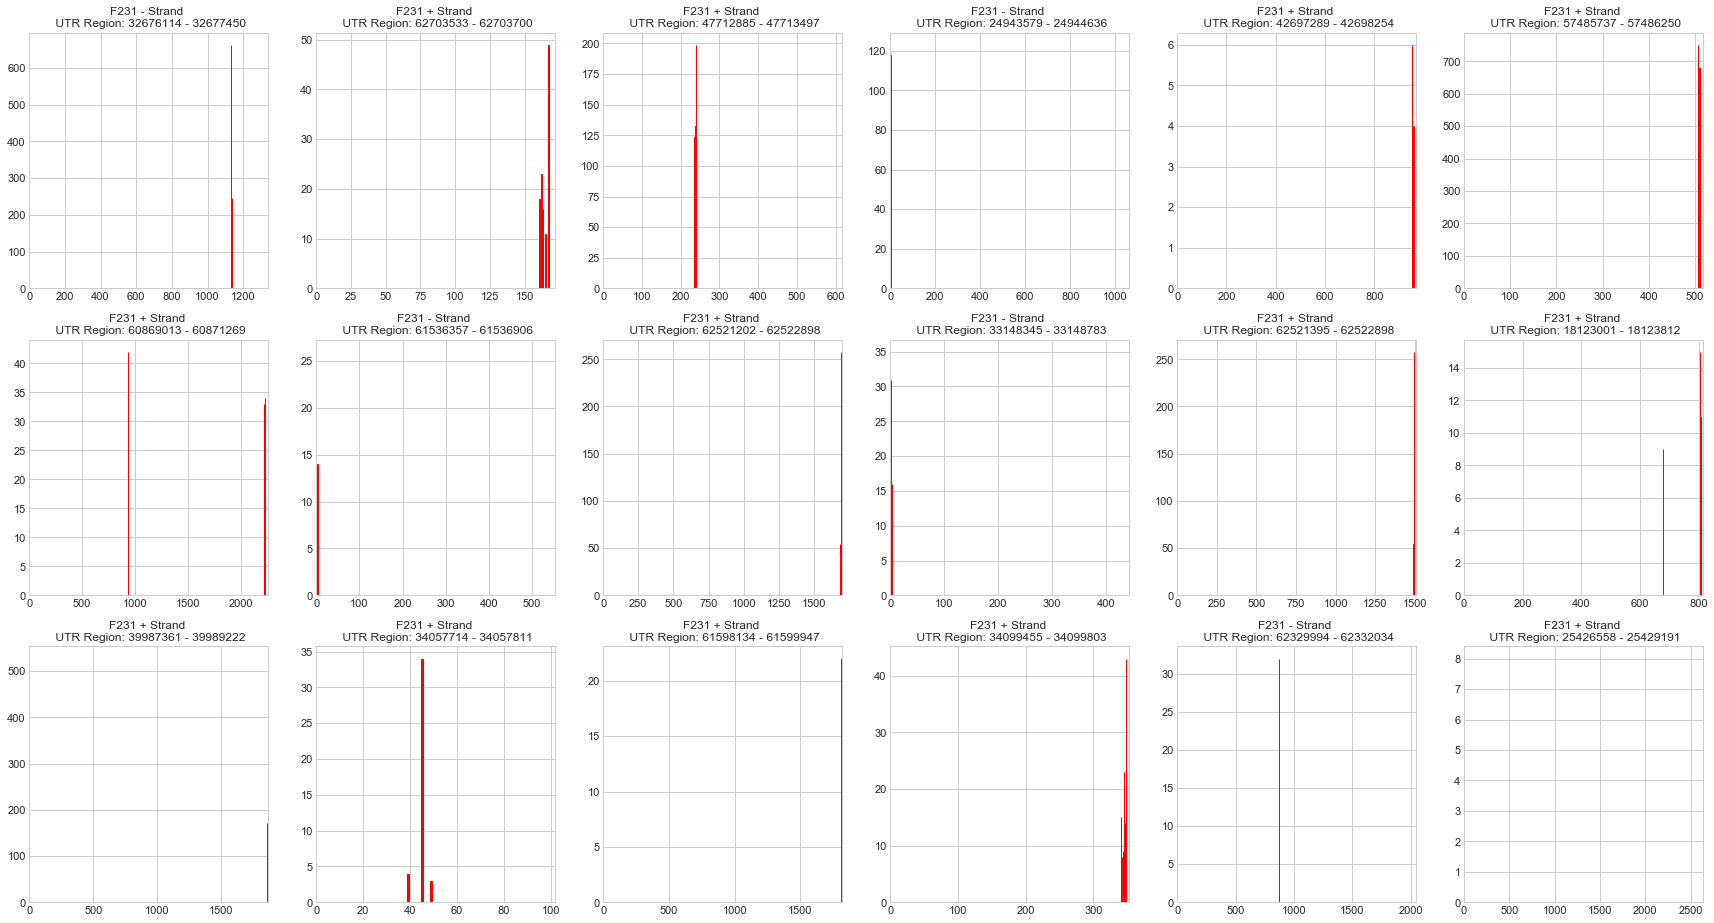

In [202]:
my_plot(which='F231')

Plotting dataset in F4175


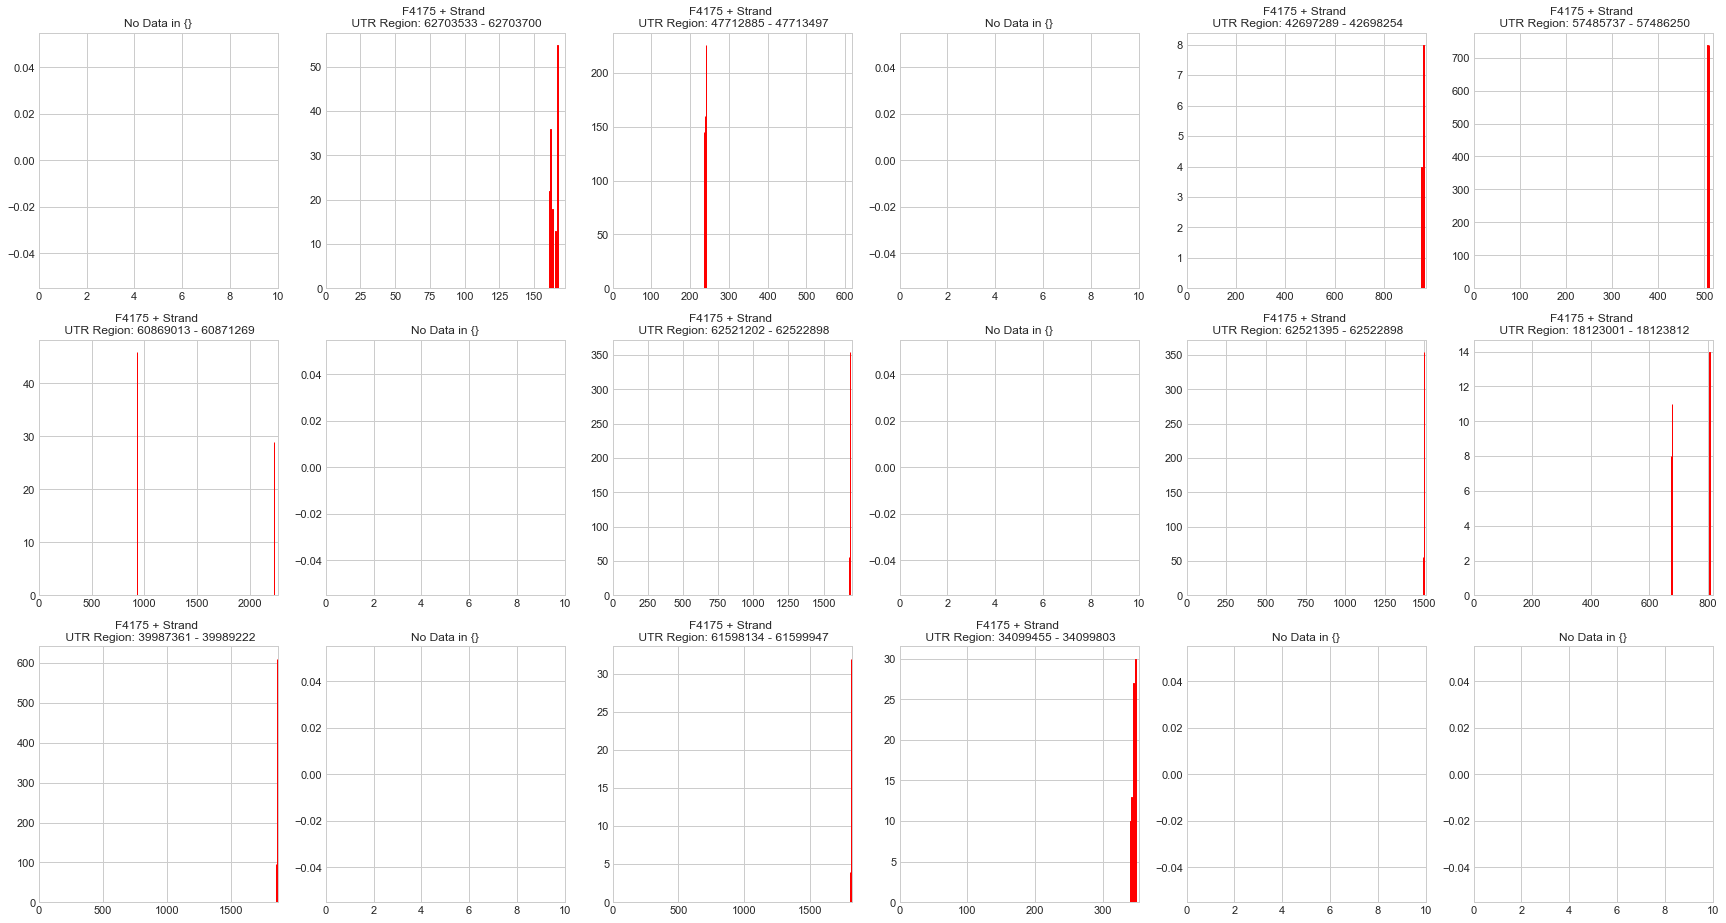

In [203]:
my_plot(which='F4175')

---

Below is an approach that I did not use. 
- It must have been recognized as "possible peak in the previous step"
- It's rank must be 2. The first two steps establishes the exact pos (or mid pos) of Peak 2. 
- Now find adjascent reads that could fall within the 25bp bin of the peak site. 
- criteria that something within Peak 2 site: within 25bp of Peak 2 pos, previously named as "possible peak"
- Then set stage for the next round (3rd) of peak detect. Criteria: distance to peak 2 pos >25 and <100


---